# Machine Learning parte 2 Otimização com exploração aleatória

## Objetivos
* Explore espaços de parâmetros de forma aleatória
* Utilize o RandomizedSearch e otimize o tempo de busca
* Compare uma exploração exaustiva com aleatória
* Execute a otimização sem validação cruzada quando aplicável

Link: https://cursos.alura.com.br/course/machine-learning-otimizacao-com-exploracao-aleatoria

## Importando as bibliotecas necessárias

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, train_test_split, KFold, GroupKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import time

from sklearn.tree import export_graphviz
import graphviz

sns.set()

## Importando os dados

In [2]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

df = pd.read_csv(uri, index_col=0)
df.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [3]:
X = df.drop('vendido', axis=1)
y = df['vendido']

seed = 301
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [4]:
df_azar = df.sort_values('vendido')
X_azar = df_azar.drop('vendido', axis=1)
y_azar = df_azar['vendido']

df_azar

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704
...,...,...,...,...
5491,71910.43,1,9,25778.40812
1873,30456.53,1,6,15468.97608
1874,69342.41,1,11,16909.33538
5499,70520.39,1,16,19622.68262


In [7]:
seed = 301
np.random.seed(seed)

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
accuracy = dummy.score(X_test, y_test)

print(f'A Acurácia do modelo dummy stratified é: {accuracy:0.2%}')

A Acurácia do modelo dummy stratified é: 58.00%


In [9]:
seed = 301
np.random.seed(seed)

param_grid = {'max_depth': [3, 5],
              'min_samples_split': [32, 64, 128],
              'min_samples_leaf': [32, 64, 128],
              'criterion': ['gini', 'entropy']} 
modelo = DecisionTreeClassifier()

clf = RandomizedSearchCV(modelo, param_grid,
                   cv=KFold(n_splits=5, shuffle=True), n_iter=16)
clf.fit(X_azar, y_azar)
resultados = pd.DataFrame(clf.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012999,0.001265,0.003001,6.327868e-04,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7755,0.7955,0.7895,0.7855,0.7740,0.7840,0.008210,12
1,0.011599,0.000800,0.002601,4.903695e-04,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.8030,0.7895,0.7855,0.7815,0.7870,0.009241,1
2,0.011000,0.001096,0.002201,4.006393e-04,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.8030,0.7895,0.7855,0.7815,0.7870,0.009241,1
3,0.019200,0.001328,0.002601,7.997397e-04,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7755,0.7955,0.7895,0.7855,0.7755,0.7843,0.007859,7
4,0.021601,0.000800,0.003001,9.464947e-07,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.7955,0.7895,0.7855,0.7755,0.7843,0.007859,7


In [12]:
scores =  cross_val_score(clf, X_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
scores_mean = scores.mean()
score_std = scores.std()
print(f'Média da acurácia: {scores_mean:0.2%}')
print(f'Intervalo da acurácia: [{scores_mean - 2 * score_std:0.2%} {scores_mean + 2 * score_std:0.2%}]')

Média da acurácia: 78.69%
Intervalo da acurácia: [76.26% 81.12%]


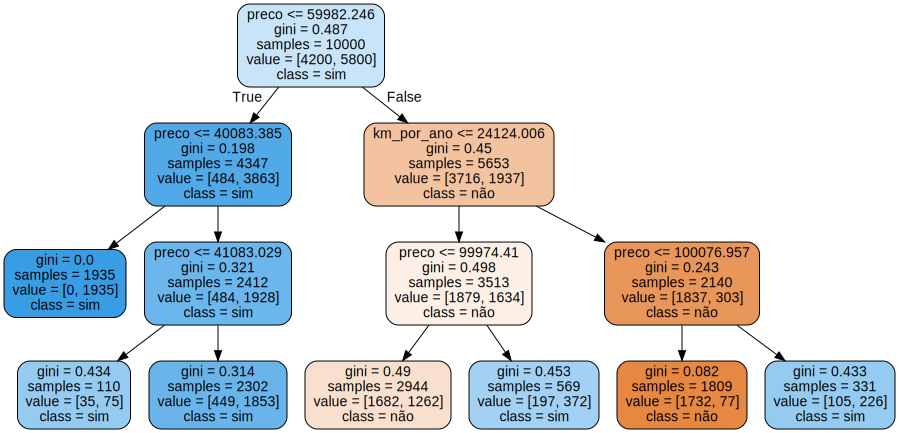

In [15]:
best = clf.best_estimator_

features = X_azar.columns
dot_data = export_graphviz(best, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

## Customizando o espaço hiper parametros

In [14]:
def imprimir_resultados(scores):
    scores_mean = scores.mean()
    score_std = scores.std()
    print(f'Média da acurácia: {scores_mean:0.2%}')
    print(f'Intervalo da acurácia: [{scores_mean - 2 * score_std:0.2%} {scores_mean + 2 * score_std:0.2%}]')

In [15]:
seed = 301
np.random.seed(seed)

param_grid = {'max_depth': [3, 5, 10, 15, 20, 30, None],
              'min_samples_split': randint(32,128),
              'min_samples_leaf': randint(32,128),
              'criterion': ['gini', 'entropy']} 
modelo = DecisionTreeClassifier()

clf = RandomizedSearchCV(modelo, param_grid,
                   cv=KFold(n_splits=5, shuffle=True), n_iter=16)
clf.fit(X_azar, y_azar)
resultados = pd.DataFrame(clf.cv_results_)
resultados.head()


In [16]:
scores =  cross_val_score(clf, X_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
imprimir_resultados(scores)

Média da acurácia: 78.57%
Intervalo da acurácia: [76.39% 80.75%]


## Uma exploração mais a fundo de forma aleatória

In [23]:
seed = 301
np.random.seed(seed)

param_grid = {'max_depth': randint(2,40),
              'min_samples_split': randint(32,128),
              'min_samples_leaf': randint(32,128),
              'criterion': ['gini', 'entropy']} 
modelo = DecisionTreeClassifier()

clf = RandomizedSearchCV(modelo, param_grid,
                   cv=KFold(n_splits=5, shuffle=True), n_iter=100)
clf.fit(X_azar, y_azar)
resultados = pd.DataFrame(clf.cv_results_)
resultados.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029402,0.001855,0.002601,0.00049,entropy,18,34,127,"{'criterion': 'entropy', 'max_depth': 18, 'min...",0.7790,0.7745,0.7875,0.7595,0.7820,0.7765,0.009492,58
1,0.017200,0.000400,0.002401,0.00049,gini,12,99,100,"{'criterion': 'gini', 'max_depth': 12, 'min_sa...",0.7875,0.7845,0.7905,0.7580,0.7785,0.7798,0.011600,10
2,0.023201,0.001721,0.002400,0.00049,entropy,20,84,89,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.7875,0.7705,0.7880,0.7620,0.7800,0.7776,0.010057,41
3,0.016600,0.001496,0.002601,0.00049,gini,29,121,52,"{'criterion': 'gini', 'max_depth': 29, 'min_sa...",0.7845,0.7810,0.7905,0.7545,0.7765,0.7774,0.012330,45
4,0.024401,0.002417,0.002401,0.00049,entropy,20,75,125,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.7830,0.7785,0.7815,0.7585,0.7815,0.7766,0.009167,56


In [26]:
scores =  cross_val_score(clf, X_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
imprimir_resultados(scores)
print(clf.best_estimator_)

Média da acurácia: 78.61%
Intervalo da acurácia: [77.09% 80.13%]
DecisionTreeClassifier(max_depth=3, min_samples_leaf=118, min_samples_split=65)


### Comparando o GridSearchCV com RandomizedSearchCV

In [31]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(X_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 208.84 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037503,0.002146,0.005201,0.000748,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.368545,0.033531,0.030797,0.014693,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.064204,0.031792,0.005401,0.000800,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.357428,0.005083,0.025402,0.001625,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.038603,0.001199,0.006201,0.000749,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [35]:
resultados_ordenados = resultados.sort_values('mean_test_score', ascending=False)
for _, linha in resultados_ordenados[:5].iterrows():
    print(f'{linha.mean_test_score:0.2%} -- {linha.std_test_score * 2:0.2%} -- {linha.params}')

78.01% -- 2.03% -- {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
77.84% -- 2.02% -- {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
77.82% -- 3.00% -- {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
77.79% -- 2.71% -- {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
77.76% -- 3.32% -- {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [37]:
tic = time.time()
scores =  cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_que_passou = tac - tic
print(f'Tempo {tempo_que_passou:0.2f} segundos')
imprimir_resultados(scores)

Tempo 894.87 segundos
Média da acurácia: 77.15%
Intervalo da acurácia: [75.81% 78.49%]


In [47]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter=20,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(X_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 32.64 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.456435,0.020403,0.026802,0.000748,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.065406,0.016343,0.006601,0.002059,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.587246,0.008256,0.028602,0.001744,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.042202,0.001470,0.005202,0.000980,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.059005,0.003847,0.005400,0.000800,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [48]:
resultados_ordenados = resultados.sort_values('mean_test_score', ascending=False)
for _, linha in resultados_ordenados[:5].iterrows():
    print(f'{linha.mean_test_score:0.2%} -- {linha.std_test_score * 2:0.2%} -- {linha.params}')

77.61% -- 2.51% -- {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
77.56% -- 2.27% -- {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
77.56% -- 2.38% -- {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
77.55% -- 3.20% -- {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
77.54% -- 3.46% -- {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [49]:
tic = time.time()
scores =  cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_que_passou = tac - tic
print(f'Tempo {tempo_que_passou:0.2f} segundos')
imprimir_resultados(scores)

Tempo 135.87 segundos
Média da acurácia: 77.59%
Intervalo da acurácia: [76.47% 78.71%]


In [51]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10,101),
    "max_depth" : randint(3,6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter=80,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(X_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 110.15 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.369028,0.005329,0.022403,0.001357,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.294423,0.003930,0.020403,0.001021,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.304824,0.048922,0.019002,0.000895,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.186814,0.004535,0.014110,0.000479,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.284623,0.007606,0.018401,0.001020,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


In [52]:
resultados_ordenados = resultados.sort_values('mean_test_score', ascending=False)
for _, linha in resultados_ordenados[:5].iterrows():
    print(f'{linha.mean_test_score:0.2%} -- {linha.std_test_score * 2:0.2%} -- {linha.params}')

77.90% -- 2.46% -- {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
77.85% -- 3.11% -- {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
77.79% -- 3.15% -- {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
77.75% -- 2.38% -- {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
77.71% -- 2.87% -- {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


In [53]:
tic = time.time()
scores =  cross_val_score(busca, X_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_que_passou = tac - tic
print(f'Tempo {tempo_que_passou:0.2f} segundos')
imprimir_resultados(scores)

Tempo 494.41 segundos
Média da acurácia: 77.24%
Intervalo da acurácia: [75.49% 78.99%]


### Em caso onde não é possível fazer cross validation

Precisamos dividir o dataset em 3 partes, para ser utilizada em cada fase da contrução do modelo:

1. A primeira fase de treino do modelo, na busca de otimizar os hiper parametros
2. A segunda fase de teste para testar qual o melhor modelo
3. A última fase de validação, tentando alcançar uma estimativa real desse algorítimo

In [58]:
# 0.6 treino    => treino
# 0.2 teste     => dev teste
# 0.2 validação => validação
SEED=301
np.random.seed(SEED)

X_train_test, X_validacao, y_treino_test, y_validacao = train_test_split(X_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)
print(X_train_test.shape)
print(X_validacao.shape)
print(y_treino_test.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [60]:
SEED=301
np.random.seed(SEED)

split = StratifiedShuffleSplit(n_splits = 1, test_size=25)

espaco_de_parametros = {
    "n_estimators" : randint(10,101),
    "max_depth" : randint(3,6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter=5,
                    cv = split)
busca.fit(X_train_test, y_treino_test)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.92 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.370425,0.0,0.010999,0.0,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.64,0.64,0.0,1
1,0.311023,0.0,0.011003,0.0,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.64,0.64,0.0,1
2,0.284022,0.0,0.010001,0.0,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.64,0.64,0.0,1
3,0.198530,0.0,0.009001,0.0,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.64,0.64,0.0,1
4,0.286141,0.0,0.011002,0.0,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.64,0.64,0.0,1


In [62]:
tic = time.time()
scores =  cross_val_score(busca, X_validacao, y_validacao, cv=split)
tac = time.time()
tempo_que_passou = tac - tic
print(f'Tempo {tempo_que_passou:0.2f} segundos')
scores

Tempo 0.46 segundos


array([0.8])